# Psycholinguistic classifier

In [21]:
%load_ext autoreload
%autoreload 2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, AdaBoostClassifier, AdaBoostRegressor, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import roc_curve, auc

from matplotlib import pyplot as plt
%matplotlib inline  

from data import Data

import pandas as pd

import numpy as np

import kenlm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_csv('utils/Psycholinguistic_Features.txt', sep='\t')
df_mean = df.mean(axis=0)

lm_books = kenlm.LanguageModel('/home/leabdro/Documentos/language_models/model_books.lm')
lm_news = kenlm.LanguageModel('//home/leabdro/Documentos/language_models/model_news.lm')

training_data = ['datasets/english/News_Train.tsv',
                 'datasets/english/WikiNews_Train.tsv',
                 'datasets/english/Wikipedia_Train.tsv',
                ]
dev_data = ['datasets/english/News_Dev.tsv',
            'datasets/english/WikiNews_Dev.tsv',
            'datasets/english/Wikipedia_Dev.tsv'
           ]

In [4]:
data_train = Data()
data_train.load_data(training_data)

data_dev = Data()
data_dev.load_data(dev_data)

In [5]:
def get_lm(lm_books, lm_news, tokens):
    model = {'per_book':0, 'per_news':0}    
    model['per_book'] = lm_books.score(' '.join(tokens), bos=False, eos=False)
    model['per_news'] = lm_news.score(' '.join(tokens), bos=False, eos=False)
    serie = pd.Series(model, index=model.keys())
    return pd.DataFrame([serie])

def get_psicolinguistics(df, df_mean, words):
    psicos = []
    for word in words:
        psico = {'Familiarity': 0, 'Age_of_Acquisition':0,
                 'Concreteness':0,'Imagery': 0}
        infos = df[df.Word == word]
        if not infos.empty:
            for key in psico.keys():
                psico[key] += infos[key].values[0]
        else:
            for key in psico.keys():
                psico[key] += df_mean[key]
        psicos.append(pd.Series(psico, index=psico.keys()))
    return pd.DataFrame(psicos).mean()

def get_features(df, df_mean, lm_books, lm_news, instances):
    x = pd.DataFrame()
    for instance in instances:
        y = pd.DataFrame()
        tokens = [instance.tokens[i] for i in instance.target]
        y = y.append(get_psicolinguistics(df, df_mean, tokens), ignore_index=True)
        lm = get_lm(lm_books, lm_news, tokens)
        y[lm.columns] = lm
        x = x.append(y)
    return x.reset_index()

def print_roc(pred, y, message='Roc curve'):
    fpr, tpr, _ = roc_curve(y.ravel(), pred.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(message)
    plt.legend(loc="lower right")
    plt.show()

In [6]:
x_train = get_features(df, df_mean, lm_books, lm_news, data_train.instances)
y_train = np.array([instance.label[0] for instance in data_train.instances])

x_dev = get_features(df, df_mean, lm_books, lm_news, data_dev.instances)
y_dev = np.array([instance.label[0] for instance in data_dev.instances])

In [7]:
x_train = x_train.drop(columns=['index'])
x_dev = x_dev.drop(columns=['index'])

In [36]:
def grid_search_classifiers(model, params):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold, scoring='roc_auc')
    grid_result = grid_search.fit(x_train, y_train)
    print(grid_result.best_params_)
    
def grid_search_regressors(model, params):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold, scoring='neg_mean_absolute_error')
    grid_result = grid_search.fit(x_train, y_train)
    print(grid_result.best_params_)

-----
# Predicting

## LogisticRegression

In [26]:
model = LogisticRegression()
param_grid = {
  'C': [0.001,0.01,0.1,1,10,100,1000],
 'penalty':['l1', 'l2']
}
grid_search_classifiers(model, param_grid)

{'C': 100, 'penalty': 'l1'}


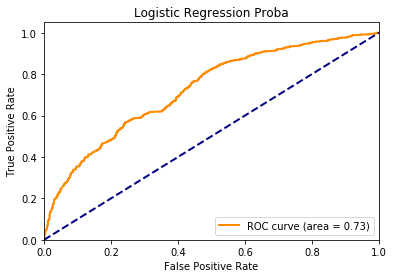

In [24]:
reg = LogisticRegression(C=10, penalty='l1')
reg.fit(x_train, y_train)
pred = reg.predict_proba(x_dev)[:, 1:]
print_roc(pred, y_dev, 'Logistic Regression Proba')

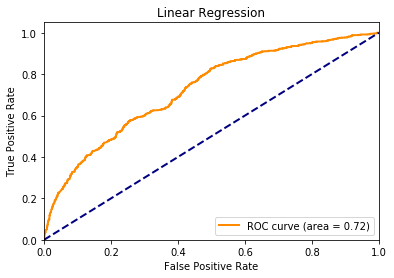

In [230]:
reg = LinearRegression()
reg.fit(x_train, y_train)
pred = reg.predict(x_dev)
print_roc(pred, y_dev, 'Linear Regression')

In [37]:
model = tree = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20],
    'max_depth': [None, 2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features':[None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20]
}
grid_search_classifiers(model, param_grid)

{'min_samples_split': 20, 'max_depth': None, 'min_samples_leaf': 10, 'criterion': 'gini', 'max_features': None, 'max_leaf_nodes': None}


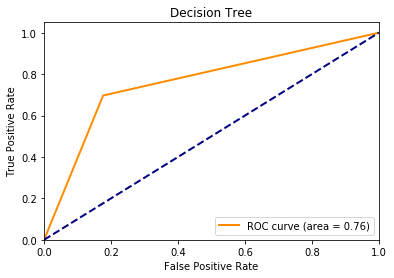

In [38]:
tree = DecisionTreeClassifier(
    min_samples_split=20,
    max_depth=5,
    min_samples_leaf=10,
    criterion='gini')
tree.fit(x_train, y_train)
pred = tree.predict(x_dev)
print_roc(pred, y_dev, 'Decision Tree')

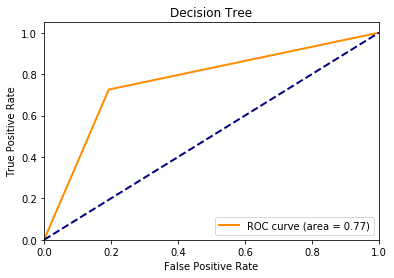

In [30]:
tree = DecisionTreeClassifier(
    min_samples_split=2,
    max_depth=5,
    min_samples_leaf=1,
    criterion='entropy')
tree.fit(x_train, y_train)
pred = tree.predict(x_dev)
print_roc(pred, y_dev, 'Decision Tree')

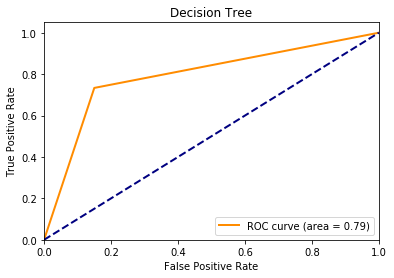

In [231]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
pred = tree.predict(x_dev)
print_roc(pred, y_dev, 'Decision Tree')

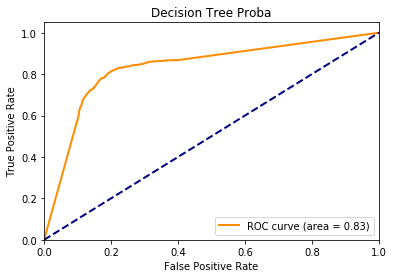

In [234]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
pred = tree.predict_proba(x_dev)[:, 1:]
print_roc(pred, y_dev, 'Decision Tree Proba')

In [31]:
model = AdaBoostClassifier()
param_grid = {
    'n_estimators':[10, 50, 100, 200, 300],
    'learning_rate': [1, 0.1, 0.001, 0.0001]}
grid_search_classifiers(model, param_grid)

{'n_estimators': 300, 'learning_rate': 0.001}


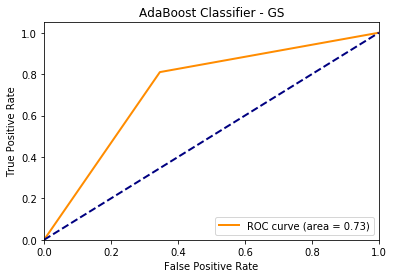

In [32]:
ensemb = AdaBoostClassifier(
    n_estimators=300,
    learning_rate=0.001)
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'AdaBoost Classifier - GS')

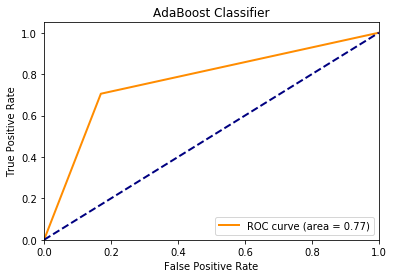

In [255]:
ensemb = AdaBoostClassifier()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'AdaBoost Classifier')

In [34]:
model = AdaBoostRegressor()
param_grid = {
    'n_estimators':[10, 50, 100, 200, 300],
    'learning_rate': [1, 0.1, 0.001, 0.0001],
     'loss':['linear', 'square', 'exponential']}
grid_search_regressors(model, param_grid)

{'n_estimators': 100, 'loss': 'exponential', 'learning_rate': 0.0001}


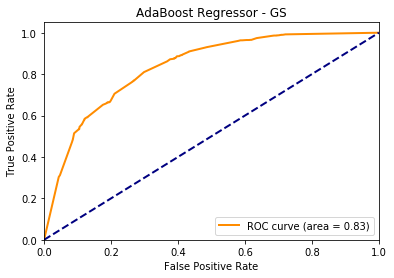

In [35]:
ensemb = AdaBoostRegressor(
    n_estimators=100,
    learning_rate=0.0001,
    loss='exponential')
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'AdaBoost Regressor - GS')

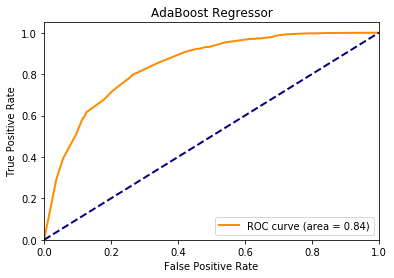

In [256]:
ensemb = AdaBoostRegressor()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'AdaBoost Regressor')

In [39]:
model = BaggingClassifier()
param_grid = {
    'n_estimators':[10, 50, 100, 200, 300]}
grid_search_regressors(model, param_grid)

{'n_estimators': 300}


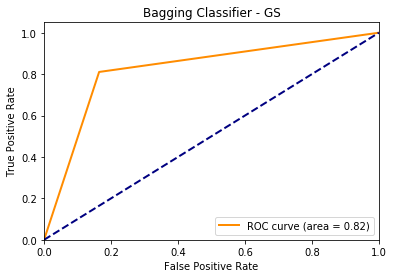

In [42]:
ensemb = BaggingClassifier(n_estimators=300)
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'Bagging Classifier - GS')

In [43]:
model = BaggingRegressor()
param_grid = {
    'n_estimators':[10, 50, 100, 200, 300]}
grid_search_regressors(model, param_grid)

{'n_estimators': 200}


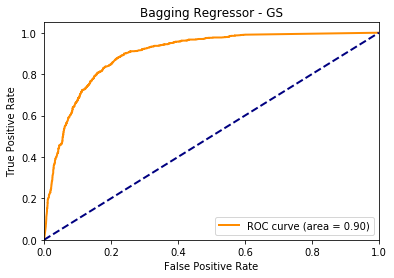

In [44]:
ensemb = BaggingRegressor(n_estimators=200)
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'Bagging Regressor - GS')

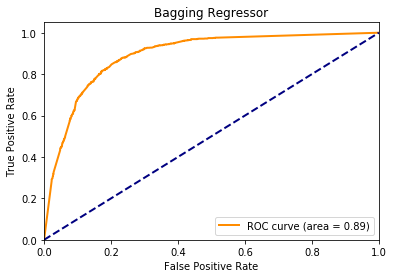

In [251]:
ensemb = BaggingRegressor()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'Bagging Regressor')

In [45]:
model = tree = ExtraTreesClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20],
    'max_depth': [None, 2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features':[None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20]
}
grid_search_classifiers(model, param_grid)

{'min_samples_split': 20, 'max_depth': None, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': None, 'max_leaf_nodes': None}


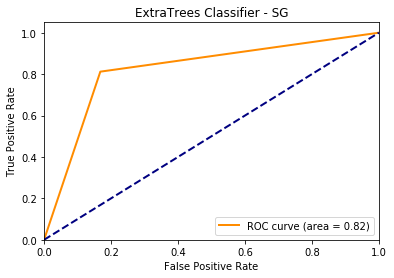

In [47]:
ensemb = ExtraTreesClassifier(
    min_samples_split=20,
    min_samples_leaf=1,
    criterion='entropy')
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'ExtraTrees Classifier - SG')

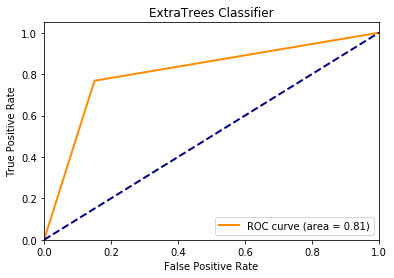

In [258]:
ensemb = ExtraTreesClassifier()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'ExtraTrees Classifier')

In [ ]:
model = ExtraTreesRegressor()
param_grid = {
    'criterion':['mse', 'mae'],
    'min_samples_split': [2, 10, 20],
    'max_depth': [None, 2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features':[None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20]}
grid_search_regressors(model, param_grid)

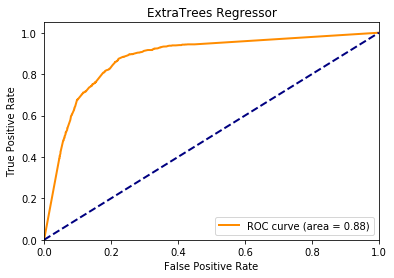

In [259]:
ensemb = ExtraTreesRegressor()
ensemb.fit(x_train, y_train)
pred = ensemb.predict(x_dev)
print_roc(pred, y_dev, 'ExtraTrees Regressor')

-----
# Tests

* target words not in psycholinguistic_features

In [110]:
# count = 0
# errors = []
# for instance in data_train.instances:
#     for target in instance.target:
#         try:
#             if len(df[df.Word == instance.tokens[target]].index) == 0:
#                 count += 1
#                 errors.append(instance.tokens[target])
#         except:
#             print(target, instance.target_chars, instance.tokens)
# print('%d / %d' % (count, len(data_train.instances)))
# print(list(set(errors)))

4014 / 27299
['', 'kabul', 'crackdown', 'goldenbridge', 'targeted', 'mla', 'amygdala', 'brevard', 'blek', 'teammate', 'jarvis', 'radars', 'cooperation', 'cernan', 'thumbs-up', 'stanković', 'gardner', 'luhman', 'bos', 'islamist', 'refinance', 'lockdown', 'tawam', 'kong', 'atropos', 'primetime', 'lt', 'bbc', 'dibenzenechromium', 'dvd', 'césar', 'organometallic', 'pompeii', 'asia', 'samsung', 'six-hour', 'nestmates', 'oriente', 'nasser', 'al-burnhanieh', 'london-based', 'iczn', 'perkasie', 'caspicara', 'maakond', 'itunes', 'pushkin', 'schengen', 'scm', 'brp', 'ibm', 'obamacare', 'moesian', 'pupates', 'kcvo', 'signings', 'premiered', 'kremlin-dominated', 'confusingly', 'choe', 'murad', 'karam', 'ex-soviet', 'primeiro', 'disabled/handicapped', 'fernando', 'worldwide', 'noorughli', 'doskozil', 'bosnia', 'mimar', 'eyewitnesses', 'kcb', 'timeline', 'psni', 'keita', 'rosenkavalier', '“', 'utc', 'hudson', 'gliese', 'favorites', 'shalygina', 'jaeg', 'six-point', 'thespis', 'temer', 'magherafelt',